In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import sqrt
from numpy import array
from numpy import split
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
dailyData = pd.read_csv('../../dataset/dailyData.csv', low_memory=False, infer_datetime_format=True, index_col=['DateTime'], header=0, parse_dates=['DateTime'])

c:\users\mimos\anaconda3\envs\tf_cpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1320      0.032     -4.125      0.000      -0.195      -0.069
ar.L2         -0.7979      0.039    -20.693      0.000      -0.873      -0.722
ar.L3          0.3345      0.035      9.689      0.000       0.267       0.402
ar.L4          0.0418      0.034      1.215      0.224      -0.026       0.109
ma.L1         -0.4545      0.021    -21.500      0.000      -0.496      -0.413
ma.L2          0.5349      0.022     24.014      0.000       0.491       0.579
ma.L3         -0.8665      0.022    -40.300      0.000      -0.909      -0.824
ar.S.L7        0.0921      0.031      3.000      0.003       0.032       0.152
ar.S.L14       0.0290      0.028      1.054      0.292      -0.025       0.083
sigma2      1.965e+05   6849.771     28.682      0.000    1.83e+05     2.1e+05
1113
3390.46
ARIMA[4, 1, 3]x[2, 0, 0, 7] - AIC:16357

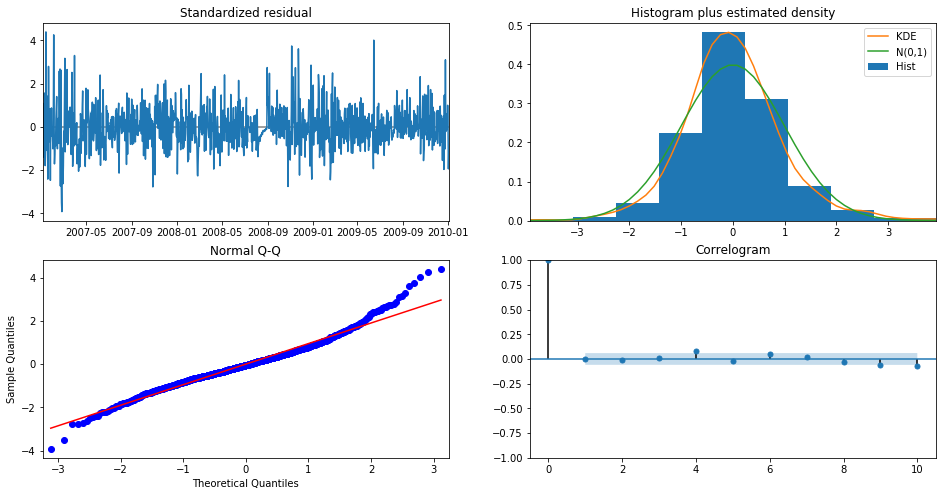

In [4]:
param_seasonal = [2,0,0,7]
pdq = [4,1,3]

dailyGAP = dailyData['Global_active_power']
dailyGAP_train = dailyGAP['2006-12-17':'2010-01-02']

mod = sm.tsa.statespace.SARIMAX(dailyGAP_train,
                                order = pdq,
                                seasonal_order= param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)


results = mod.fit()
print(results.summary().tables[1])
rmse = sqrt(mean_squared_error(results.fittedvalues, dailyGAP_train))
residuals = dailyGAP_train - results.fittedvalues
print(len(residuals))
print(residuals[0])
print('ARIMA{}x{} - AIC:{} -RMSE:{}'.format(pdq, param_seasonal, results.aic, rmse))
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
residuals = pd.DataFrame(residuals)
scaled = scaler.fit_transform(residuals)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())
print(len(reframed))

   var1(t-1)   var1(t)
1   1.000000  0.163924
2   0.163924  0.469684
3   0.469684  0.185519
4   0.185519  0.183703
5   0.183703  0.595455
1112


(1084, 1, 1) (1084,) (28, 1, 1) (28,)
Train on 1084 samples, validate on 28 samples
Epoch 1/20
 - 1s - loss: 0.1054 - val_loss: 0.0762
Epoch 2/20
 - 0s - loss: 0.0567 - val_loss: 0.0362
Epoch 3/20
 - 0s - loss: 0.0245 - val_loss: 0.0144
Epoch 4/20
 - 0s - loss: 0.0105 - val_loss: 0.0091
Epoch 5/20
 - 0s - loss: 0.0086 - val_loss: 0.0092
Epoch 6/20
 - 0s - loss: 0.0086 - val_loss: 0.0090
Epoch 7/20
 - 0s - loss: 0.0085 - val_loss: 0.0090
Epoch 8/20
 - 0s - loss: 0.0085 - val_loss: 0.0089
Epoch 9/20
 - 0s - loss: 0.0084 - val_loss: 0.0089
Epoch 10/20
 - 0s - loss: 0.0083 - val_loss: 0.0089
Epoch 11/20
 - 0s - loss: 0.0082 - val_loss: 0.0088
Epoch 12/20
 - 0s - loss: 0.0086 - val_loss: 0.0088
Epoch 13/20
 - 0s - loss: 0.0084 - val_loss: 0.0087
Epoch 14/20
 - 0s - loss: 0.0083 - val_loss: 0.0087
Epoch 15/20
 - 0s - loss: 0.0081 - val_loss: 0.0087
Epoch 16/20
 - 0s - loss: 0.0084 - val_loss: 0.0086
Epoch 17/20
 - 0s - loss: 0.0083 - val_loss: 0.0086
Epoch 18/20
 - 0s - loss: 0.0079 - val_lo

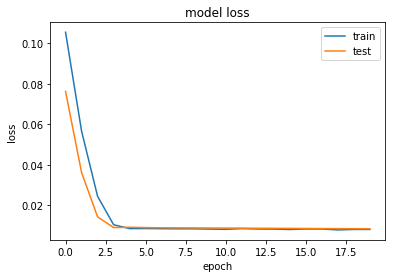

Test RMSE: 478.893


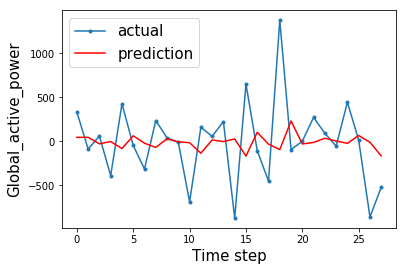

In [8]:
values = reframed.values

n_train_time = 1112 - 28
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(28)]
plt.plot(aa, inv_y[:28], marker='.', label="actual")
plt.plot(aa, inv_yhat[:28], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

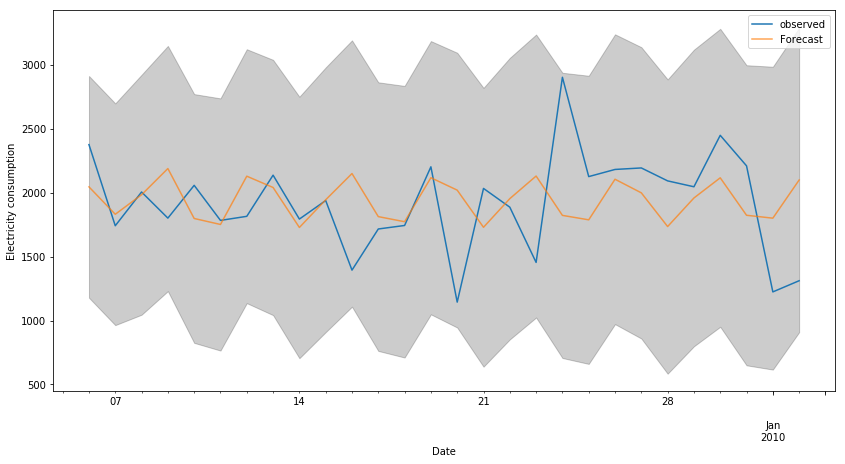

RMSE:423.800087977648


In [11]:
start_date = '2009-12-06'
end_date = '2010-01-02'

pred = results.get_prediction(start = start_date, end = end_date, dynamic=1)
pred_ci = pred.conf_int()

ax = dailyGAP[start_date:end_date].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

temp = []
for i in range(len(inv_yhat)):
    temp.append(inv_yhat[i])
test_predict = temp

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption')
plt.legend()

plt.show()

rmse = sqrt(mean_squared_error(pred.predicted_mean+inv_yhat, dailyGAP[start_date:end_date].values))
print('RMSE:{}'.format(rmse))